In [84]:
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer

window = 1
N = 2
n_epochs = 600
corpus = ["My name is Mohammad Amin, and I love NLP."]
eta = 0.1

First we need to tokenize the corpus and initialize some weights.

In [85]:
def tokenize(corpus):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    corpus_tokenized = tokenizer.texts_to_sequences(corpus)
    V = len(tokenizer.word_index)
    return corpus_tokenized, V

def initialize(V, N):
    np.random.seed(100)
    W1 = np.random.rand(V, N)
    W2 = np.random.rand(N, V)

    return W1, W2

corpus_tokenized, V = tokenize(corpus)


Here we try to convert the corpus into the pairs of center and context.

In [86]:
def corpus_to_cc(corpus_tokenized, V, window):
    for words in corpus_tokenized:
        L = len(words)
        for index, word in enumerate(words):
            contexts = []
            center = []
            s = index - window
            e = index + window + 1
            contexts = contexts + [words[i]-1 for i in range(s, e) if 0 <= i < L and i != index]
            center.append(word-1)
            # x has shape c x V where c is size of contexts
            x = np_utils.to_categorical(contexts, V)
            # y has shape k x V where k is number of center words
            y = np_utils.to_categorical(center, V)
            yield (x, y)


    

We try to calculate softmax based on the formula.

In [87]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

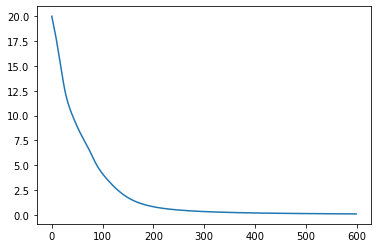

In [88]:
def cbow(context, label, W1, W2, loss):
        # context: all the context words (these represent the inputs)
        # label: the center word (this represents the label)
        # W1: weights from the input to the hidden layer
        # W2: weights from the hidden to the output layer
        # loss: float that represents the current value of the loss function

        # context is 'x' from tokenizer, it is a c x V matrix
        # label is 'y' from tokenizer, it is a 1 x V matrix
        
        x = np.matrix(np.mean(context, axis=0))
        
        # x is a 1 x V matrix
        # W1 is a V x N matrix
        # h is a N x 1 matrix
        h = np.matmul(W1.T, x.T)
        
        # u is a V x 1 matrix
        u = np.matmul(W2.T, h)
        
        # W2 is an N x V matrix
        # y_pred is a V x 1 matrix
        y_pred = softmax(u)
        # e is a V x 1 matrix
        e = -label.T + y_pred
        # h is N x 1 and e is V x 1 so dW2 is N x V
        dW2 = np.outer(h, e)
        # x.T is a V x 1 matrix, W2e is a Nx1 so dW1 this is V x N
        dW1 = np.outer(x.T, np.matmul(W2, e))

        new_W1 = W1 - eta * dW1
        new_W2 = W2 - eta * dW2

        # label is a 1xV matrix so label.T is a Vx1 matrix
        loss += -float(u[label.T == 1]) + np.log(np.sum(np.exp(u)))

        return new_W1, new_W2, loss

W1, W2 = initialize(V, N)
loss_vs_epoch = []
for e in range(n_epochs):
    loss = 0.
    for context, center in corpus_to_cc(corpus_tokenized, V, window):
        W1, W2, loss = cbow(context, center, W1, W2, loss)
    loss_vs_epoch.append(loss)
plt.plot(loss_vs_epoch)
plt.show()

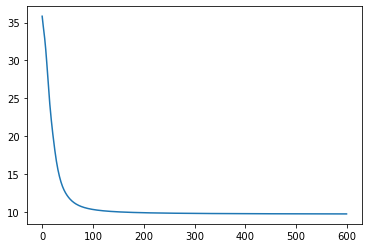

In [89]:
def skipgram(context, x, W1, W2, loss):
        # context: all the context words (these represent the labels)
        # x: the center word (this represents the input)
        # W1: weights from the input to the hidden layer
        # W2: weights from the hidden to the output layer
        # loss: float that represents the current value of the loss function

        # context is "x" from tokenizer, it is a c x V matrix
        # "x" is "y" from tokenizer, it is a 1 x V matrix
        # W1 has dimension V x N
        # x has dimension V x 1
        h = np.matmul(W1.T, x.T)
        # h has dimension N x 1
        # W2 has dimension N x V
        # u has dimension V x 1
        u = np.dot(W2.T, h)
        # y_pred has dimension V x 1
        y_pred = softmax(u)

        # context is a c by V matrix
        # e is a V x c matrix
        e = np.outer(y_pred,np.array([1]*context.shape[0]))-context.T

        # h is an N x 1 Vector
        # dW2 is a N x V matrix
        dW2 = np.outer(h, np.sum(e, axis=1))
        # x is a V x 1 matrix
        # dW1 is an V x N matrix
        dW1 = np.outer(x, np.dot(W2, np.sum(e, axis=1)))

        new_W1 = W1 - eta * dW1
        new_W2 = W2 - eta * dW2

        loss += - np.sum([u[label.T == 1] for label in context]) + len(context) * np.log(np.sum(np.exp(u)))

        return new_W1, new_W2, loss

W1, W2 = initialize(V, N)
loss_vs_epoch = []
for e in range(n_epochs):
    loss = 0.
    for context, center in corpus_to_cc(corpus_tokenized, V, window):
        W1, W2, loss = skipgram(context, center, W1, W2, loss)
    loss_vs_epoch.append(loss)
plt.plot(loss_vs_epoch)
plt.show()

With the help of some Github repositories and a few tutorials, I could implement cbow and skip-gram and show the loss over epochs. I learned a few things about negative sampling and hierarchical softmax, which I mention below.
### Negative Sampling:
- Our positive samples are within the window, and we randomly choose a few negative samples out of the window to train the model. This way, we ignore training on all corpus in each epoch and will not lose considerable precision. However, we reduce the training cost so much.
### Hierarchical Sampling: 
- We make a Huffman tree in which we have each word in the leaves. Each of the words can be reached by a path from the root through the inner nodes, which represent probability mass along that way. In this way, we achieve the O(log(V)) and have a reasonable estimation of the softmax function. Actually, the simple softmax is a tree of depth 1.

#### Implementing Negative Sampling would not be that hard, but hierarchical softmax requires more reading.

